## Modelo Hodgkin-Huxley de 3 dimensiones para células piramidales del CA1 del hipocampo 

### Herramientas de librerías 

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

In [27]:
import scipy as sc
from scipy import integrate
import numpy as np

### Diccionario 

In [28]:
# Diccionario de parámetros 
p = {} # Diccionario vacío 
p['EK'] = -89.0 # Potencial de Nernst para el potasio K+
p['ENa']= 65.0 # Potencial de Nernst para el sodio Na+
p['ECa']= 128.0 # Potencial de Nernst para el calcio Ca+2
p['EL']= -58.0 # Potencial de Nernst para la corriente de fuga
p['gK']= 60.0 # Conductancia del potasio K+
p['gK(Ca)']= 5.0 # Conductancia del potasio dependiente de calcio 
p['gNa']= 10.0 # Conductancia del sodio Na+
p['gCa']= 0.3 # Conductancia del calcio 
p['gL']= 0.01 # Conductancia de fuga
p['aMean'] = 0.0 # Media del proceso OU
p['aSD'] = 5.0 # Desviación estándar (amplitud del ruido)
p['aTau'] = 10.0 # Constante de tiempo (inverso de reversión a la media)
p['vTCm'] = 1.0 # Factor de escala/normalización
p['useOU'] = True # Bandera para activar/desactivar el ruido OU
p['v12x']= 3.0
p['v12m']= -19.0 # Potencial de semi-activación para la corriente del sodio Na+
p['v12w']=-1.0 # Potencial de semi-activación para la corriente del potasio K+
p['mp']= 3 # Exponente de activación para canal de Na+
p['wp']= 4 # Exponente de activación para canal de K+
p['am']=0.054 # Control de la pendiente de la curva de activación para canales de Na+ (qué tan abruptamente se activan)
p['aw']=0.055 # Control de la pendiente de la curva de activación para canales de K+ (qué tan abruptamente se activan)
p['ax']= 0.2
p['lambda']= 0.08 # Factor de escala para las pendientes de curvas de activación
p['taux'] = 1.0
p['Kp']= 3.0e-6 
p['Kd']= 7.4e-4
p['R']= 0.0045
p['upStart']=200.0 # Inicio de la fase de despolarización del estímulo de la corriente
p['upStop']=200.01 # Fin de la fase de despolarización del estímulo de corriente
p['dnStart']=1000.0 # Inicio de fase de repolarización del estímulo de corriente
p['dnStop']=1000.01 # Fin de fase de repolarización del estímulo de corriente
p['rampAmp']=30.0 # Amplitud del estímulo de corriente
p['s']= 1.0 # Factor de escala de las pendientes de las curvas de activación
p['Cm']=1.0 # Capacitancia membranal específica 
p['step'] = 0.001 # Paso de tiempo de la simulación 
p['tmin']= 0.0 # Tiempo mínimo de la simulación
p['tmax']= 3000.0 # Tiempo máximo de la simulación
p['sampTimes'] = np.arange(p['tmin'],p['tmax'],p['step']) # Arreglo de tiempo 
p['cmin'] = 0.0001
p['w0']=0.001 # Condición inicial de w, para activación de canales de K+ 
p['v0']=-70.0 # Condición inicial de v: potencial de equilibrio de la membrana (aproximadamente)
p['c0']=0.0001  # Condición inicial para la concentración de calcio
p['z0']= (p['v0'],p['w0'],p['c0']) # Condición inicial para las cuatro variables del sistema

### Función de inyección de corriente

In [29]:
def UpTopDn(t,upStart=200.0,upStop=400, dnStart=600.0,dnStop=800.0,rampAmp=1.0):
    slope_up = rampAmp/(upStop-upStart) # Pendiente de la recta de subida
                                        # Variar rampAmp nos daría qué tan sensible es al cambio la pendiente de recta de subida 
                                        # Variar upStop o upStart nos da la variación del cambio 
    int_up = -slope_up*upStart # Cálculo de b (la recta empieza en y=0)
                               # int_up cumple el papel de b
                               # Estamos en la parte inferior de la rampa
                               # Por ello la pendiente de subida y el incio de subida nos dan b
    slope_dn = -rampAmp/(dnStop-dnStart) # Pendiente de la recta de bajada
                                         # Ahora rampAmp nos da también la sensibilidad al cambip de la pendiente de bajada
                                         # Por ello ahora el inicio y término del descenso nos dan la variación del cambio
    int_dn= rampAmp-slope_dn*dnStart # Cálculo de b (la recta empieza en y=rampAmp)
                                     # Aquí int_dn hace el papel de b
                                     # Aquí estamos arriba de la rampa, por ello y=rampAmp
                                     # Por ello mismo la pendiente de bajada y el inicio de bajada nos dan b
    c1=np.int16((upStart<t)&(t<=upStop)) # Condición booleana para recta de subida
                                         # Es cuando el tiempo es mayor al tiempo de subida
                                         # Pero menor al tiempo de término subida
                                         # Por ello estamos subiendo
    c2=np.int16((upStop<t)&(t<=dnStart)) # Condición booleana para estancia en rampAmp
                                         # El tiempo ya superó el momento de detener subida 
                                         # Pero es menor al tiempo de iniciar bajada
                                         # Por ello nos mantenemos fijos en rampAmp 
    c3=np.int16((t>dnStart)&(t<=dnStop)) # Condición booleana para recta de bajada
                                         # Finalmente el tiempo superó el tiempo de iniciar bajada 
                                         # Pero es menor al tiempo de detener bajada
                                         # Es decir, ya estamos bajando para llegar otra vez al punto de inicio de la rampa
    y=c1*(slope_up*t +int_up)+ c2*rampAmp+ c3*(slope_dn*t +int_dn) # Recta resultante sometida a cada condición booleana
                                                                   # Dependiendo del tiempo, determinamos si estamos
                                                                   # Subiendo, fijos en rampAmp o bajando.
    return y # Justamente "y" es lo que sube, baja o se mantiene fijo  

In [30]:
def ouForcing(p, seed=None): # Usamos seed para la reproducibilidad 
    
    if seed is not None:
        np.random.seed(seed) # Así generamos la alateoridad necesaria 
        
    timeSamples = np.arange(0, p['tmax'], p['step'])
    nSteps = len(timeSamples) # Nuestro vector de tiempo
    
    # Parámetros del proceso OU
    theta = 1.0 / p['aTau']  # parámetro de reversión a la media
    mu = p['aMean']          # media a largo plazo
    sigma = np.sqrt(2 * p['aSD'] * theta)  # volatilidad
    
    # Inicializar array
    ou_path = np.zeros(nSteps) # Vector para guardar la señal
    ou_path[0] = mu  # empezar en la media
    
    # Generar proceso OU usando el método de Euler-Maruyama
    for t in range(1, nSteps):
        dt = p['step']
        
    # Ecuación OU: dx = theta*(mu - x)*dt + sigma*dW
        drift = theta * (mu - ou_path[t-1]) * dt
        diffusion = sigma * np.sqrt(dt) * np.random.normal()
        ou_path[t] = ou_path[t-1] + drift + diffusion
    
    return ou_path / p['vTCm'] # Normalización por si acaso

### Ecuaciones diferenciales e integración de la corriente

In [31]:
def rhs(z,t): # Función para obtener las derivadas de nuestras variables de interés (V, W)
    v,w,c = z # Damos las dos variables del sistema 
            # Es decir, el voltaje V y la sensibilidad o probabilidad de que se abran 
            # los canales de K+ 
            # Y se las asignamos z vector de estado que nos va a dar las variables
            # que dependen del tiempo
    
 # Encuentra el índice del tiempo actual para obtener el valor OU correspondiente
    t_index = min(int(t / p['step']), len(p['ouNoise']) - 1)
    ou_current = p['ouNoise'][t_index] if p['useOU'] else 0.0

    
    winf = 1.0/( 1.0+ np.exp(-2*p['aw']*(v-p['v12w']))) # Activación de los canales de K+ en estado estacionario
                                                        # Vemos cómo la activación de los canales efectivamente
                                                        # depende del voltaje. Para los canales de K+ sabemos
                                                        # que tenemos w. Si variamos aw la activación es más 
                                                        # abrupta o suave dependiendo de si aumenta o disminuye
                                                        # respectivamente. Aumentar o disminuir v12w nos da
                                                        # mayor o menor facilidad para que se abran. De esa forma 
                                                        # se obtiene un mayor o menor potencial de acción.
    minf = 1.0/( 1.0+ np.exp(-2*p['am']*(v-p['v12m'])))# Activación de los canales de Na+ en estado estacionario
                                                        # Es análogo para los canales de Na+, pero con m. A su vez
                                                        # am nos da una activación más abrupta o suave de acuerdo 
                                                        # a su aumento o disminución. Para v12m aumentarlo dificulta
                                                        # los potenciales de acción y bajarlo hace a la neurona
                                                        # más excitable
    xinf = 1.0/( 1.0 + np.exp(-2*p['ax']*(v-p['v12x'])))
    
    tauw = 1.0/( p['lambda']*np.exp(p['aw']*(v-p['v12w']))+ \
               p['lambda']*np.exp(-p['aw']*(v-p['v12w']))) 
    taux = 1.0/( p['lambda']*np.exp(p['ax']*(v-p['v12x']))+ \
               p['lambda']*np.exp(-p['ax']*(v-p['v12x']))) # Funciones de tiempo de relajación de los canales de K+
                                                           # Aquí se controla la duración del potencial de acción
                                                           # lambda al crecer causa disminución en tau y eso se 
                                                           # traduce en una respuesta más rápida de los canales
                                                           # de K+. Consecuentemente, la disminución de lambda 
                                                           # aumenta a tau y nos da una respuesta más lenta de los 
                                                           # canales de K+
    
    INa = p['gNa']*minf**p['mp']*(1-w)*(v-p['ENa']) # Corriente de Na+
                                                    # Aumentar la conductancia gNa nos da potenciales de acción
                                                    # más grandes y rápidos. Disminuirla nos da potenciales de acción
                                                    # menores y lentos. Ena nos dice qué tan positivo va a ser
                                                    # el potencial de acción. Y mp dirá qué tan abrupta es la activación
    IK = p['gK']*(w/p['s'])**p['wp']*(v-p['EK']) # Corriente de K+
                                                 # La conductancia gK causa potenciales de acción más cortos y una 
                                                 # repolarización más rápida. Para EK, cambia la "profundidad"
                                                 # de la hiperpolarización y wp afecta la linealidad de la corriente
    IL = p['gL']*(v-p['EL']) # Corriente de fuga
                             # Aquí nuestra conductancia gL va a determinar qué tan fácil o difícil
                             # será excitar nuestra neurona.Y EL directamente va a mover el potencial de equilibrio
    ICa = p['gCa']*xinf*(v-p['ECa']) # Corriente de calcio

    IKCa = p['gK(Ca)']*(c/(p['Kd']+c))*(v-p['EK']) # Corriente de potasio dependiente de calcio 
    
    IStim = lambda t: (UpTopDn(t,upStart=p['upStart'],upStop=p['upStop'],\
                               dnStart=p['dnStart'],dnStop=p['dnStop'],\
                               rampAmp=p['rampAmp'])) # El estímulo de corriente 
                                                  
    dvdt = (IStim(t) + ou_current - INa - IK - IL - IKCa - ICa)/p['Cm'] # Ecuación diferencial para el cambio del voltaje en el tiempo
                                              # Cm nos va a dar la velocidad  de los cambios en el voltaje
                                              # y, a su vez, qué tan rápida va a ser la respuesta al estímulo
    dwdt = (winf - w) / tauw # Ecuación diferencial para el cambio en la activación de los canales de K+ en el tiempo

    dcdt = p['Kp']*(-ICa) - p['R']*(c) #Ecuacion diferencial para el cambio de concentración de calcio en el tiempo
    
    return dvdt,dwdt,dcdt

### Simulación

In [32]:
def simulateHH(p):
    if p['useOU'] and 'ouNoise' not in p:
        p['ouNoise'] = ouForcing(p) # Si sí queremos el ruido lo activamos y guardamos en nuestro dic.
        
    orbit =  sc.integrate.odeint(rhs, p['z0'], p['sampTimes']).transpose() # Resolvemos el sistema de ecuaciones 
                                                                           # Para ello se utiliza el rhs creado antes
                                                                           # z0 son nuestras condiciones iniciales
                                                                           # sampTimes es en el arreglo de tiempos 
                                                                           # en el que queremos dar la solución y
                                                                           # finalmente obtenemos V y W variando en el tiempo
                                                                           # Si nuestra v0 es más positiva es más fácil disparar
                                                                           # Si es más negativa necesita más estímulo
                                                                           # Si w0 alto hay un efecto inhibitorio pues
                                                                           # hay muchos canales abiertos y consecuentemente
                                                                           # si w0 baja tenemos neurona más excitable
                                                                           # Nuestro sampTimes simplemente nos cuánto tiempo
                                                                           # y de cuánto el salto de cada tiempo
    
    v = orbit[0] # Determinamos quién es el voltaje en nuestra solución
    w = orbit[1] # Determinamos quién es la sensibilidad de los canales de K+ en nuestra solución
    c = orbit[2] # Determinamos quién es la concentración de calcio 
    
    jStim = lambda t: (UpTopDn(t,upStart=p['upStart'],upStop=p['upStop'],\
                               dnStart=p['dnStart'],dnStop=p['dnStop'],\
                               rampAmp=p['rampAmp'])) # Estímulo de corriente a aplicar 
                                                      # Acudimos a nuestro código anterior para determinar cómo
                                                      # vamos a inyectar la corriente
    winf = 1.0/( 1.0+ np.exp(-2*p['aw']*(v-p['v12w']))) # Activación de los canales de K+ en estado estacionario
    minf = 1.0/( 1.0+ np.exp(-2*p['am']*(v-p['v12m']))) # Activación de los canales de Na+ en estado estacionario
    xinf = 1.0/( 1.0 + np.exp(-2*p['ax']*(v-p['v12x'])))
    tau = 1.0/( p['lambda']*np.exp(p['aw']*(v-p['v12w']))+ \
               p['lambda']*np.exp(-p['aw']*(v-p['v12w']))) # Función de tiempo de relajación de los canales de K+
                                                           # Volvemos a calcular todas estas variables como en rhs
                                                           # porque ahora lo estamos haciendo para toda la trayectoria
                                                           # y así podemos ver el comportamiento post-simulación
    INa = p['gNa']*minf**p['mp']*(1-w)*(v-p['ENa']) # Corriente de Na+
    IK = p['gK']*(w/p['s'])**p['wp']*(v-p['EK']) # Corriente de K+
                                                 # Aquí tenemos el factor de escala "s" que nos ayuda a que los
                                                 # potenciales sean más largos o cortos dependiendo de si es más
                                                 # alto o bajo respectivamente 
    IL = p['gL']*(v-p['EL']) # Corriente de fuga
                             # Igual que en el caso anterior ahora calculamos todo esto a lo largo del tiempo
    ICa = p['gCa']*xinf*(v-p['ECa']) # Corriente de calcio

    IKCa = p['gK(Ca)']*(c/(p['Kd']+c))*(v-p['EK']) #Corriente de potasio dependiente de calcio
    
    IStim= (jStim(p['sampTimes'])) # Aplicación del estímulo para cada tiempo
    xx = {'v':v, 'w':w, 'c':c, 'sampTimes':p['sampTimes'], 'IStim':IStim, 'INa':INa,
          'IK':IK,'IL':IL, 'ICa':ICa, 'IKCa':IKCa, 'ouNoise':p['ouNoise']} # Salida de simulación con voltajes, canales de K+ y corrientes
                           # De aquí vamos a agarrar lo que querramos ver o necesitemos saber 
                           # de nuestra simulación
    #Graficación
    ax1=list()
    fig1=plt.figure(figsize=(12,8)) # Cosas de configuración de nuestra gráfica
    plt.ioff()
    rows = 4; cols=1;
    plt.subplot(rows,cols, 1)
    plt.plot(xx['sampTimes'], xx['v'], 'k')
    plt.xlim(0,p['tmax'])
    plt.ylim(-100,100)
    plt.ylabel(r'$v$ (mV)')
    plt.grid() # Mostramos evolución temporal del voltaje
    
    plt.subplot(rows,cols, 2)
    plt.plot(xx['sampTimes'], xx['IStim'], 'k')
    plt.xlim(0,p['tmax'])
    plt.ylim(0,160)
    plt.ylabel(r'$I_{Stim}$')
    plt.xlabel(r'time (ms)')
    plt.grid() # Mostramos patrón de estimulación hecho

    plt.subplot(rows,cols, 3)
    if p['useOU']:
        plt.plot(xx['sampTimes'], xx['ouNoise'], 'r', alpha=0.7)
        plt.ylabel(r'OU Noise')
        plt.ylim(-3*p['aSD']/p['vTCm'], 3*p['aSD']/p['vTCm'])
    else:
        plt.text(0.5, 0.5, 'OU Noise Disabled', transform=plt.gca().transAxes, 
                ha='center', va='center')
        plt.ylabel(r'OU Noise (disabled)')
    plt.xlim(0,p['tmax'])
    plt.grid() # Ahora, si sí queremos ruido lo graficamos 

    plt.subplot(rows,cols, 4)
    plt.plot(xx['sampTimes'], xx['c'], 'y')
    plt.xlim(0,p['tmax'])
    plt.ylabel(r'$Ca (μM)$')
    plt.xlabel(r'time (ms)')
    plt.grid() 

    plt.ion(); plt.draw(); plt.show()
    return xx

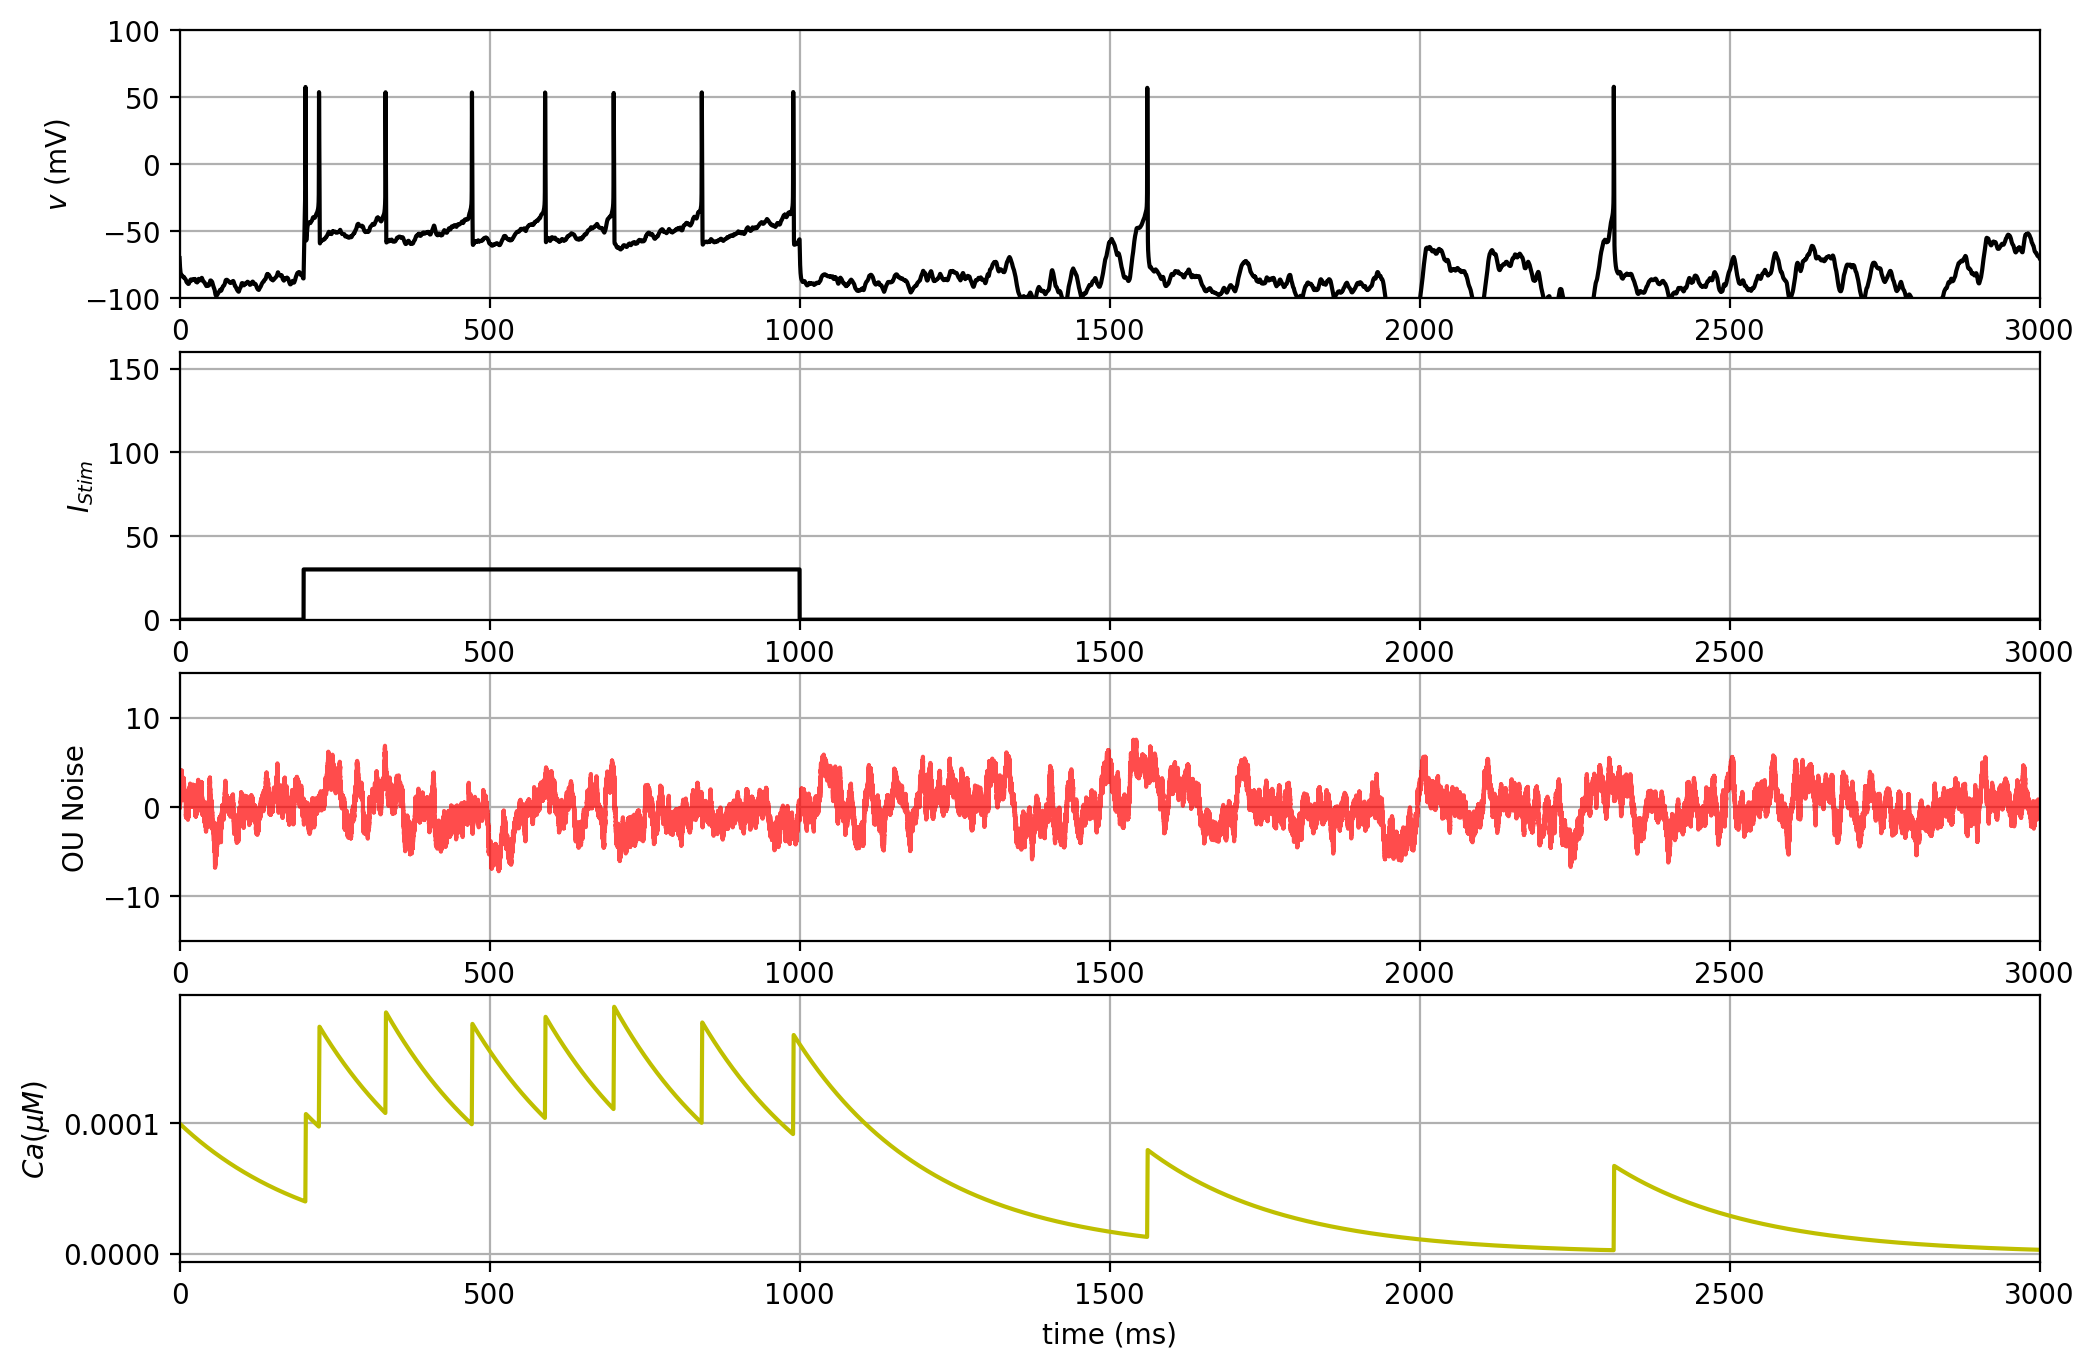

In [33]:
xx = simulateHH(p)

### Para graficar un sólo potencial de acción y sus respectivas corrientes

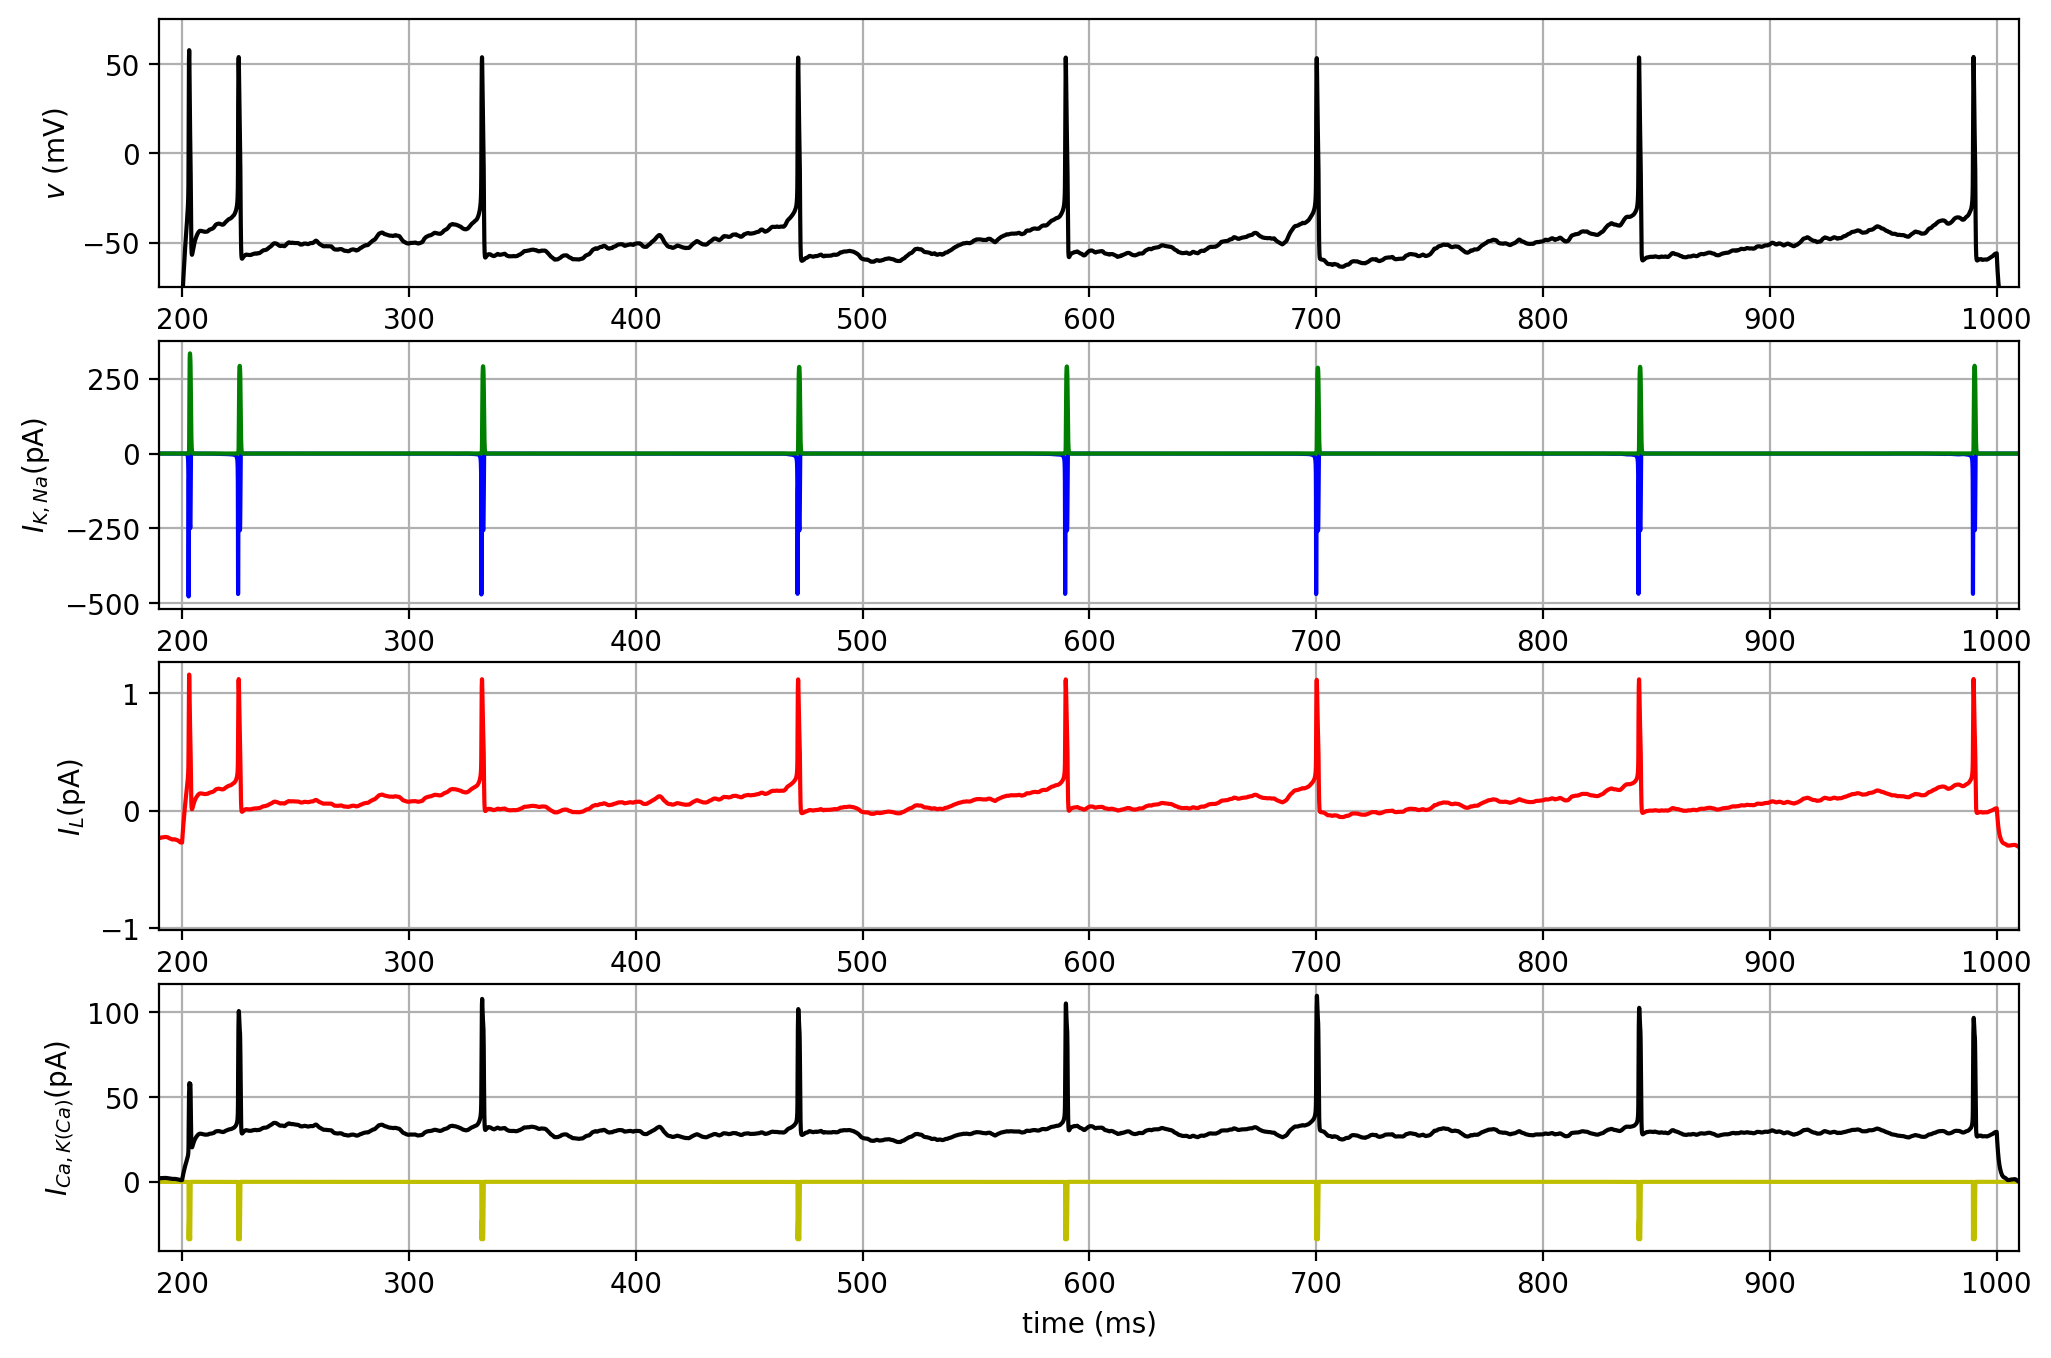

In [34]:
ax1=list()
fig1=plt.figure(figsize=(12,8)) # Configuramos detalles de la gráfica 
plt.ioff()
rows = 4; cols=1;

plt.subplot(rows,cols, 1)
plt.plot(xx['sampTimes'], xx['v'], 'k')
plt.ylim(-75,75)
plt.xlim(190,1010)
plt.ylabel(r'$v$ (mV)')
plt.grid() # Aquí graficamos potencial de membrana, es decir, potencial en el tiempo y así podemos ver
           # la forma completa del potencial de acción

plt.subplot(rows,cols, 2)
plt.plot(xx['sampTimes'], xx['INa'], 'b') # Corriente de sodio la mandamos azul 
plt.plot(xx['sampTimes'], xx['IK'], 'g')  # Corriente de potasio la mandamos verde
plt.xlim(190,1010)
plt.ylabel(r'$I_{K,Na}$(pA)')
plt.xlabel(r'time (ms)')
plt.grid() # Y graficamos 

plt.subplot(rows,cols, 3)
plt.plot(xx['sampTimes'], xx['IL'], 'r') # Finalmente mandamos la corriente de fuga con color rojo
plt.xlim(190,1010)
plt.ylabel(r'$I_{L}$(pA)')
plt.xlabel(r'time (ms)')
plt.grid() # Y graficamos 

plt.subplot(rows,cols, 4)
plt.plot(xx['sampTimes'], xx['ICa'], 'y')
plt.plot(xx['sampTimes'], xx['IKCa'], 'k')
plt.xlim(190,1010)
plt.ylabel(r'$I_{Ca,K(Ca)}$(pA)')
plt.xlabel(r'time (ms)')
plt.grid() # Y graficamos 

plt.ion(); plt.draw(); plt.show()